# Basic Notebook to train model

___
___
## Imports

In [1]:
# custom classes
from data import ClasslessImageDataset, ClasslessImageDatasetAlbCv
from model import Unet
from loss import *

# torch/-vision/album libs
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
import albumentations as A
from albumentations.pytorch import ToTensorV2

# other data and plot
import matplotlib.pyplot as plt
import numpy as np

# util
from glob import glob
from time import time
from tqdm.notebook import tqdm

device = torch.device("cuda")
#%matplotlib notebook

___
___
## Create Transforms and Dataloader
Define dataset settings and create dataloaders.  
And show little data demo.

In [2]:
# DATA_DIR = "D:\portrait"
DATA_DIR = r"D:\faces"
BATCH_SIZE = 16
IMG_SIZE = (192, 192)

In [3]:
train_transforms = A.Compose([
#     A.Flip(),
    A.Blur(),
    A.RandomBrightnessContrast(),
    A.ToGray(p=1.0),
    A.Normalize(mean=(.0), std=(1.)),
    A.Resize(IMG_SIZE[0], IMG_SIZE[0]),
    ToTensorV2(),
])

test_transforms = A.Compose([
    A.ToGray(p=1.0),
    A.Normalize(mean=(.0), std=(1.)),
    A.Resize(IMG_SIZE[0], IMG_SIZE[0]),
    ToTensorV2(),
])

target_transforms = A.Compose([
    A.Normalize(mean=(.0), std=(1.)),
    A.Resize(IMG_SIZE[0], IMG_SIZE[0]),
    ToTensorV2(),
])

In [4]:
train_ds = ClasslessImageDatasetAlbCv(DATA_DIR, split="train", transform=train_transforms, target_transform=target_transforms)
test_ds  = ClasslessImageDatasetAlbCv(DATA_DIR, split="test",  transform=test_transforms,  target_transform=target_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=True)

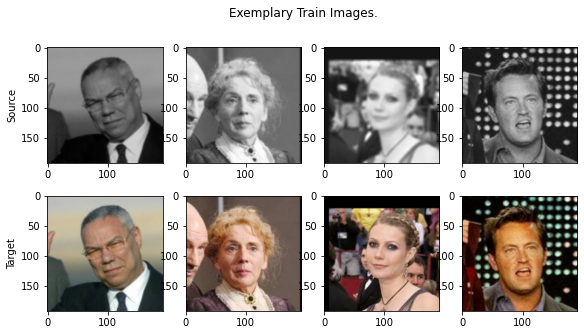

In [5]:
source, target = next(iter(train_loader))
n_images = BATCH_SIZE if BATCH_SIZE <= 4 else 4

fig, axs = plt.subplots(2, n_images, figsize = (9.5,5))
fig.suptitle('Exemplary Train Images.')
axs[0,0].set_ylabel("Source")
axs[1,0].set_ylabel("Target")

for i in range(n_images):
    axs[0,i].imshow(source[i].permute([1,2,0]), cmap="gray")
    axs[1,i].imshow(target[i].permute([1,2,0]))
plt.show()

___
___
## Create Model, Optimizer, Scheduler and Loss

In [6]:
model = Unet(
    img_size = IMG_SIZE,
    in_channels=3,
    encoder="tu-efficientnet_b2", 
    layernorm=False, 
    activation="sigmoid",
).to(device)

In [7]:
optimizer = Adam(model.parameters(), lr=3e-5)
# optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

# loss_function = nn.MSELoss()
# loss_function = nn.L1Loss(reduction="mean")
# loss_function = ColourDistMean
loss_function = ColourWeightedMSELoss

___
___
## Define train and eval step

In [8]:
def train_step(model, src_data, tgt_data, optimizer, loss_func):
    src, tgt = src_data.cuda(), tgt_data.cuda()
    
    optimizer.zero_grad()
    
    preds = model(src)
    
    loss = loss_func(preds, tgt)
    loss.backward()
    
    optimizer.step()
        
    return loss.item()

def eval_step(model, src_data, tgt_data, loss_func):
    src, tgt = src_data.cuda(), tgt_data.cuda()
    
    with torch.no_grad():
        preds = model(src)
        loss = loss_func(preds, tgt)
        
    return loss.item(), preds

___
___
## Create static images as demo 

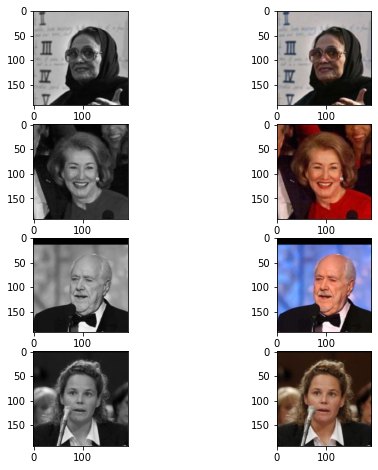

tensor(0.0071)


In [9]:
demo_images = [next(iter(test_loader)) for i in range(24)]
demo_src = torch.cat([src for (src, tgt) in demo_images])
demo_tgt = torch.cat([tgt for (src, tgt) in demo_images])

fig, axs = plt.subplots(4, 2, figsize=(8,8))
for i in range(4):
    axs[i,0].imshow(demo_src[i].permute([1,2,0]), cmap="gray")
    axs[i,1].imshow(demo_tgt[i].permute([1,2,0]))

plt.show()
print(loss_function(demo_src, demo_tgt))

___
___
## Trainloop with image demo

In [10]:
writer = SummaryWriter() # tensorboard --logdir=Documents\GitHub\deepcolor\runs --samples_per_plugin=images=100

model.eval()
_, pred_imgs = eval_step(model, demo_src, demo_tgt, loss_function)
grid = make_grid(pred_imgs)
writer.add_image('images', grid, 0)

N_EPOCHS = 50
for epoch in tqdm(range(N_EPOCHS), desc="Epoch"):
    
    train_loss = []
    model.train()
    for i_train_step, data in tqdm(enumerate(train_loader), total=len(train_loader), leave=False, desc="Train Step"):
        src, tgt = data
        
        loss = train_step(model, src, tgt, optimizer, loss_function)
        train_loss.append(loss)
        
    scheduler.step()
    writer.add_scalar('Loss/train', np.mean(train_loss), epoch+1)
    
    test_loss = []
    model.eval()
    for i_test_step, data in tqdm(enumerate(test_loader), total=len(test_loader), leave=False, desc="Test Step"):
        src, tgt = data
        
        loss, _ = eval_step(model, src, tgt, loss_function)
        test_loss.append(loss)          
        
    writer.add_scalar('Loss/test', np.mean(test_loss), epoch+1)
    
    _, pred_imgs = eval_step(model, demo_src, demo_tgt, loss_function)
    grid = make_grid(pred_imgs)
    writer.add_image('images', grid, epoch+1)

writer.close()

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]

Train Step:   0%|          | 0/734 [00:00<?, ?it/s]

Test Step:   0%|          | 0/1500 [00:00<?, ?it/s]